<a href="https://colab.research.google.com/github/CharlesSnt/PFE/blob/main/MLP_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

In [2]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import numpy as np
from itertools import product, combinations

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Xavier initialization
# -----------------------------
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


# -----------------------------
# CNN-based PINN
# -----------------------------
class PhysicsInformedCNN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, out_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            hidden_channels, hidden_channels, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            hidden_channels, hidden_channels, kernel_size=3, padding=1
        )
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)

        # Xavier initialization
        self.apply(init_weights)

    def forward(self, xyt):
        h = torch.tanh(self.conv1(xyt))
        h = torch.tanh(self.conv2(h))
        h = torch.tanh(self.conv3(h))
        out = self.out_conv(h)
        u = out[:, 0:1, :, :]
        v = out[:, 1:2, :, :]
        p = out[:, 2:3, :, :]
        return u, v, p


# -----------------------------
# Gradient helper
# -----------------------------
def gradient(y, x):
    # Compute gradient
    grad = autograd.grad(
        y,
        x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
    )[0]

    # Replace None with zeros
    if grad is None:
        grad = torch.zeros_like(x)
    return grad


# -----------------------------
# Navier-Stokes residuals
# -----------------------------
def navier_stokes_residual(model, xyt, nu=0.01):
    xyt.requires_grad_(True)
    u, v, p = model(xyt)

    # gradients w.r.t the input channels
    u_x = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0][
        :, 0:1, :, :
    ]
    u_y = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0][
        :, 1:2, :, :
    ]
    u_t = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0][
        :, 2:3, :, :
    ]

    v_x = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0][
        :, 0:1, :, :
    ]
    v_y = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0][
        :, 1:2, :, :
    ]
    v_t = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0][
        :, 2:3, :, :
    ]

    p_x = autograd.grad(p, xyt, grad_outputs=torch.ones_like(p), create_graph=True)[0][
        :, 0:1, :, :
    ]
    p_y = autograd.grad(p, xyt, grad_outputs=torch.ones_like(p), create_graph=True)[0][
        :, 1:2, :, :
    ]

    u_xx = autograd.grad(
        u_x, xyt, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1, :, :]
    u_yy = autograd.grad(
        u_y, xyt, grad_outputs=torch.ones_like(u_y), create_graph=True
    )[0][:, 1:2, :, :]

    v_xx = autograd.grad(
        v_x, xyt, grad_outputs=torch.ones_like(v_x), create_graph=True
    )[0][:, 0:1, :, :]
    v_yy = autograd.grad(
        v_y, xyt, grad_outputs=torch.ones_like(v_y), create_graph=True
    )[0][:, 1:2, :, :]

    f_u = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    f_v = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return f_u, f_v, u, v, p


# -----------------------------
# Loss function
# -----------------------------
def pinn_loss(model, xyt, u_true, v_true, nu=0.01):
    f_u, f_v, u_pred, v_pred, _ = navier_stokes_residual(model, xyt, nu)
    mse_data = ((u_pred - u_true) ** 2).mean() + ((v_pred - v_true) ** 2).mean()
    mse_pde = (f_u**2).mean() + (f_v**2).mean()
    return mse_data + mse_pde


# -----------------------------
# Training function
# -----------------------------
def train(model, xyt, u_true, v_true, adam_iters=5000, lbfgs_iters=500):
    model.to(device)
    xyt = xyt.to(device)
    u_true = u_true.to(device)
    v_true = v_true.to(device)

    # --- Adam warmup ---
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for it in range(adam_iters):
        optimizer.zero_grad()
        loss = pinn_loss(model, xyt, u_true, v_true)
        loss.backward()
        optimizer.step()
        if it % 100 == 0:
            print(f"Adam iter {it}, loss={loss.item():.3e}")

    # --- LBFGS fine-tuning ---
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        max_iter=lbfgs_iters,
        tolerance_grad=1e-9,
        tolerance_change=1e-9,
        history_size=50,
        line_search_fn="strong_wolfe",
    )

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = pinn_loss(model, xyt, u_true, v_true)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)


# -----------------------------
# Helper function for 3D aspect
# -----------------------------
def axisEqual3D(ax):
    extents = np.array([getattr(ax, "get_{}lim".format(dim))() for dim in "xyz"])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    ax.set_xlim3d([centers[0] - r, centers[0] + r])
    ax.set_ylim3d([centers[1] - r, centers[1] + r])
    ax.set_zlim3d([centers[2] - r, centers[2] + r])


Adam iter 0, loss=1.062e+00
Adam iter 100, loss=1.577e-01
Adam iter 200, loss=1.539e-01
Adam iter 300, loss=1.513e-01
Adam iter 400, loss=1.315e-01
Starting LBFGS optimization...
u_pred.shape: torch.Size([5000, 1, 1, 1])
v_pred.shape: torch.Size([5000, 1, 1, 1])
Adam iter 0, loss=9.545e-02
Adam iter 100, loss=9.522e-02
Adam iter 200, loss=9.506e-02
Adam iter 300, loss=9.488e-02
Adam iter 400, loss=9.467e-02
Starting LBFGS optimization...
Error u: 1.685e-01
Error v: 1.023e+00
Error p: 1.167e+00
Adam iter 0, loss=2.203e-01
Adam iter 100, loss=1.595e-01
Adam iter 200, loss=1.574e-01
Adam iter 300, loss=1.566e-01
Adam iter 400, loss=1.561e-01
Starting LBFGS optimization...
Noisy Error u: 3.135e-01
Noisy Error v: 1.006e+00
Noisy Error p: 1.047e+00


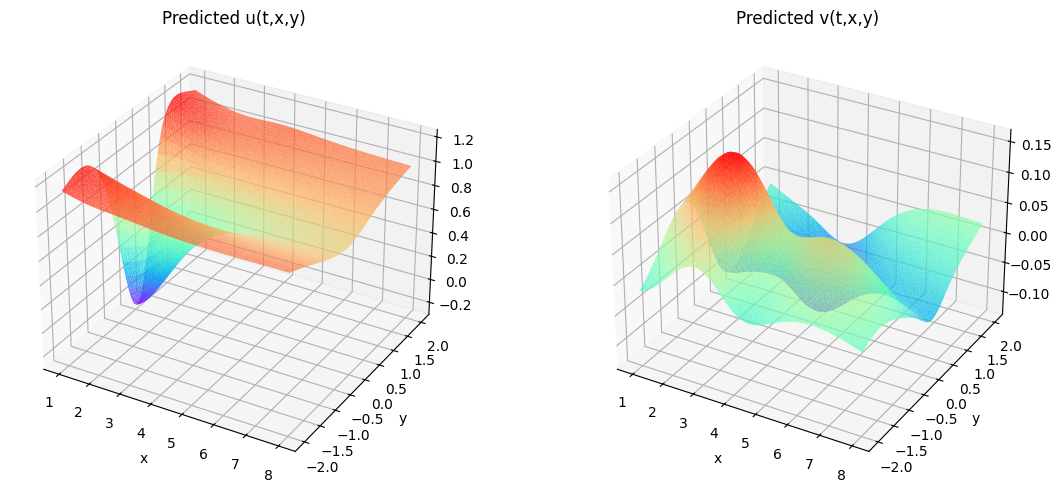

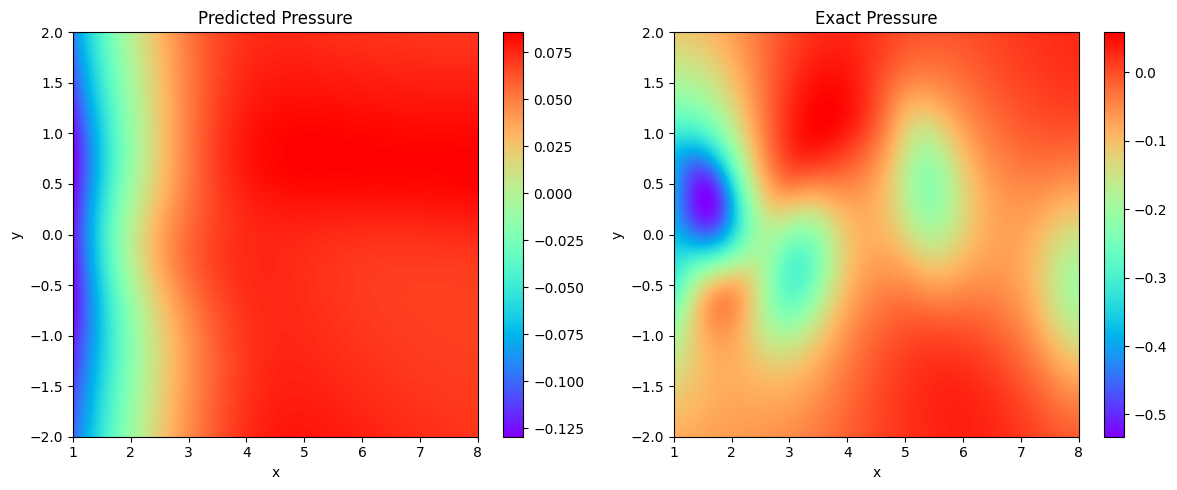

Errors on clean data:
u: 1.685e-01, v: 1.023e+00, p: 1.167e+00
Errors on noisy data:
u: 3.135e-01, v: 1.006e+00, p: 1.047e+00


In [4]:

# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    # Load Data
    data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")
    U_star = data["U_star"]
    P_star = data["p_star"]
    t_star = data["t"]
    X_star = data["X_star"]

    N = X_star.shape[0]
    T = t_star.shape[0]

    XX = np.tile(X_star[:, 0:1], (1, T))
    YY = np.tile(X_star[:, 1:2], (1, T))
    TT = np.tile(t_star, (1, N)).T

    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]
    PP = P_star[:, 0]

    x = XX.flatten()[:, None]
    y = YY.flatten()[:, None]
    t = TT.flatten()[:, None]
    u = UU.flatten()[:, None]
    v = VV.flatten()[:, None]

    # Random training sample
    N_train = 5000
    idx = np.random.choice(N * T, N_train, replace=False)
    x_train = torch.tensor(x[idx, :], dtype=torch.float32)
    y_train = torch.tensor(y[idx, :], dtype=torch.float32)
    t_train = torch.tensor(t[idx, :], dtype=torch.float32)
    u_train = torch.tensor(u[idx, :], dtype=torch.float32)
    v_train = torch.tensor(v[idx, :], dtype=torch.float32)

    x_train.requires_grad_(True)
    y_train.requires_grad_(True)
    t_train.requires_grad_(True)

    # Stack inputs for CNN: [batch, channels, H, W]
    xyt_train = (
        torch.cat([x_train, y_train, t_train], dim=1).unsqueeze(-1).unsqueeze(-1)
    )
    xyt_train.requires_grad_(True)

    u_train = u_train.unsqueeze(-1).unsqueeze(-1)  # shape [N,1,1,1]
    v_train = v_train.unsqueeze(-1).unsqueeze(-1)

    # Build model
    model = PhysicsInformedCNN(in_channels=3, hidden_channels=32, out_channels=3)

    # Train
    train(model, xyt_train, u_train, v_train, adam_iters=500, lbfgs_iters=200)

    # Test example snapshot
    snap_idx = 100
    x_star_s = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device) # Moved to device
    y_star_s = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device) # Moved to device
    t_star_s = torch.tensor(TT[:, snap_idx], dtype=torch.float32).unsqueeze(1).to(device) # Moved to device

    xyt_test = (
        torch.cat([x_star_s, y_star_s, t_star_s], dim=1).unsqueeze(-1).unsqueeze(-1)
    )
    u_pred, v_pred, p_pred = model(xyt_test)
    print("u_pred.shape:", u_pred.shape)
    print("v_pred.shape:", v_pred.shape)

    p_star = P_star[:, snap_idx]

    # ----------------------------------------------------------------------
    # Noiseless Data
    # ----------------------------------------------------------------------
    # Training Data (already sampled)
    x_train_np = x_train.detach().cpu().numpy()
    y_train_np = y_train.detach().cpu().numpy()
    t_train_np = t_train.detach().cpu().numpy()

    u_train_np = u_train.detach().cpu().numpy()
    v_train_np = v_train.detach().cpu().numpy()
    p_train_np = p_pred.squeeze(-1).squeeze(-1).detach().cpu().numpy()

    # Train the model
    train(model, xyt_train, u_train, v_train, adam_iters=500, lbfgs_iters=200)

    # Test Data: snapshot
    snap_idx = 100
    x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device)
    y_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device)
    t_star = torch.tensor(TT[:, snap_idx], dtype=torch.float32).unsqueeze(1).to(device)

    xyt_test = torch.cat([x_star, y_star, t_star], dim=1).unsqueeze(-1).unsqueeze(-1)
    u_pred, v_pred, p_pred = model(xyt_test)

    # Convert predictions to numpy for comparison/plotting
    u_pred_np = u_pred.detach().cpu().numpy().squeeze()
    v_pred_np = v_pred.detach().cpu().numpy().squeeze()
    p_pred_np = p_pred.detach().cpu().numpy().squeeze()

    # True snapshot
    u_star = U_star[:, 0, snap_idx]
    v_star = U_star[:, 1, snap_idx]
    p_star = P_star[:, snap_idx]

    # Errors
    error_u = np.linalg.norm(u_star - u_pred_np, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred_np, 2) / np.linalg.norm(v_star, 2)
    error_p = np.linalg.norm(p_star - p_pred_np, 2) / np.linalg.norm(p_star, 2)

    print(f"Error u: {error_u:.3e}")
    print(f"Error v: {error_v:.3e}")
    print(f"Error p: {error_p:.3e}")

    # ----------------------------------------------------------------------
    # Noisy Data
    # ----------------------------------------------------------------------
    noise = 0.01
    u_train_noisy = u_train_np + noise * np.std(u_train_np) * np.random.randn(
        *u_train_np.shape
    )
    v_train_noisy = v_train_np + noise * np.std(v_train_np) * np.random.randn(
        *v_train_np.shape
    )

    # Convert back to tensors
    u_train_noisy_t = (
        torch.tensor(u_train_noisy, dtype=torch.float32)
        .unsqueeze(-1)
        .unsqueeze(-1)
        .to(device)
    )
    v_train_noisy_t = (
        torch.tensor(v_train_noisy, dtype=torch.float32)
        .unsqueeze(-1)
        .unsqueeze(-1)
        .to(device)
    )

    # Train again with noisy data
    train(
        model,
        xyt_train,
        u_train_noisy_t,
        v_train_noisy_t,
        adam_iters=500,
        lbfgs_iters=200,
    )

    # Predict again
    u_pred_noisy, v_pred_noisy, p_pred_noisy = model(xyt_test)
    u_pred_noisy_np = u_pred_noisy.detach().cpu().numpy().squeeze()
    v_pred_noisy_np = v_pred_noisy.detach().cpu().numpy().squeeze()
    p_pred_noisy_np = p_pred_noisy.detach().cpu().numpy().squeeze()

    # Compute errors if desired
    error_u_noisy = np.linalg.norm(u_star - u_pred_noisy_np, 2) / np.linalg.norm(
        u_star, 2
    )
    error_v_noisy = np.linalg.norm(v_star - v_pred_noisy_np, 2) / np.linalg.norm(
        v_star, 2
    )
    error_p_noisy = np.linalg.norm(p_star - p_pred_noisy_np, 2) / np.linalg.norm(
        p_star, 2
    )

    print(f"Noisy Error u: {error_u_noisy:.3e}")
    print(f"Noisy Error v: {error_v_noisy:.3e}")
    print(f"Noisy Error p: {error_p_noisy:.3e}")

    # -----------------------------
    # Interpolation for plotting
    # -----------------------------
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x_grid = np.linspace(lb[0], ub[0], nn)
    y_grid = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x_grid, y_grid)

    UU_star = griddata(X_star, u_pred_np.flatten(), (X, Y), method="cubic")
    VV_star = griddata(X_star, v_pred_np.flatten(), (X, Y), method="cubic")
    PP_star = griddata(X_star, p_pred_np.flatten(), (X, Y), method="cubic")
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method="cubic")

    # -----------------------------
    # Plot 3D u and v fields
    # -----------------------------
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 2)
    ax_u = fig.add_subplot(gs[0, 0], projection="3d")
    ax_v = fig.add_subplot(gs[0, 1], projection="3d")

    ax_u.plot_trisurf(X_star[:, 0], X_star[:, 1], u_pred_np, cmap="rainbow", alpha=0.8)
    ax_u.set_title("Predicted u(t,x,y)")
    ax_u.set_xlabel("x")
    ax_u.set_ylabel("y")

    ax_v.plot_trisurf(X_star[:, 0], X_star[:, 1], v_pred_np, cmap="rainbow", alpha=0.8)
    ax_v.set_title("Predicted v(t,x,y)")
    ax_v.set_xlabel("x")
    ax_v.set_ylabel("y")

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot pressure field (2D)
    # -----------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    im0 = ax[0].imshow(
        PP_star,
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        cmap="rainbow",
        aspect="auto",
    )
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_title("Predicted Pressure")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    im1 = ax[1].imshow(
        P_exact,
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        cmap="rainbow",
        aspect="auto",
    )
    fig.colorbar(im1, ax=ax[1])
    ax[1].set_title("Exact Pressure")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Print table of errors
    # -----------------------------
    print("Errors on clean data:")
    print(f"u: {error_u:.3e}, v: {error_v:.3e}, p: {error_p:.3e}")
    print("Errors on noisy data:")
    print(f"u: {error_u_noisy:.3e}, v: {error_v_noisy:.3e}, p: {error_p_noisy:.3e}")

# MLP

In [1]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.nn.utils import parameters_to_vector

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Initialization
# -----------------------------
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


# -----------------------------
# Model Class - MLP (remplace le CNN)
# -----------------------------
class PhysicsInformedMLP(nn.Module):
    """
    MLP pour prédire directement u, v, p
    Architecture: [3] -> [20, 20, 20, 20, 20, 20, 20, 20] -> [3]
    """
    def __init__(self, layers=[3, 20, 20, 20, 20, 20, 20, 20, 20, 3]):
        super().__init__()

        self.layers_sizes = layers
        self.num_layers = len(layers) - 1

        # Construction du MLP
        self.network = nn.ModuleList()
        for i in range(self.num_layers):
            self.network.append(nn.Linear(layers[i], layers[i+1]))

        self.apply(init_weights)

    def forward(self, xyt):
        """
        Args:
            xyt: tensor de shape (N, 3) avec [x, y, t]

        Returns:
            u, v, p: tensors de shape (N, 1) chacun
        """
        # Si xyt a des dimensions supplémentaires (comme dans ton code avec unsqueeze)
        # on les aplatit d'abord
        if xyt.dim() > 2:
            original_shape = xyt.shape
            xyt = xyt.view(-1, 3)
            needs_reshape = True
        else:
            needs_reshape = False

        h = xyt

        # Propagation à travers les couches cachées avec tanh
        for i in range(self.num_layers - 1):
            h = torch.tanh(self.network[i](h))

        # Dernière couche (linéaire)
        out = self.network[-1](h)

        # Séparer u, v, p
        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]

        # Remettre la forme originale si nécessaire
        if needs_reshape:
            u = u.view(original_shape[0], 1, original_shape[2], original_shape[3])
            v = v.view(original_shape[0], 1, original_shape[2], original_shape[3])
            p = p.view(original_shape[0], 1, original_shape[2], original_shape[3])

        return u, v, p


# -----------------------------
# Physics (Navier-Stokes) - CORRIGÉ
# -----------------------------
def navier_stokes_residual(model, xyt, nu=0.01):
    """
    Calcule les résidus de Navier-Stokes
    CORRECTION: Ajoute l'équation de continuité pour l'incompressibilité
    """
    # Aplatir si nécessaire
    if xyt.dim() > 2:
        batch_size = xyt.shape[0]
        xyt = xyt.view(batch_size, 3)

    xyt.requires_grad_(True)

    # Prédiction du modèle
    u, v, p = model(xyt)

    # Aplatir les sorties si elles ont des dimensions supplémentaires
    if u.dim() > 2:
        u = u.view(-1, 1)
        v = v.view(-1, 1)
        p = p.view(-1, 1)

    # Dérivées de u
    u_g = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y, u_t = u_g[:, 0:1], u_g[:, 1:2], u_g[:, 2:3]

    # Dérivées de v
    v_g = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y, v_t = v_g[:, 0:1], v_g[:, 1:2], v_g[:, 2:3]

    # Dérivées de p
    p_g = autograd.grad(p, xyt, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y = p_g[:, 0:1], p_g[:, 1:2]

    # Dérivées secondes de u
    u_xx = autograd.grad(
        u_x, xyt, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1]
    u_yy = autograd.grad(
        u_y, xyt, grad_outputs=torch.ones_like(u_y), create_graph=True
    )[0][:, 1:2]

    # Dérivées secondes de v
    v_xx = autograd.grad(
        v_x, xyt, grad_outputs=torch.ones_like(v_x), create_graph=True
    )[0][:, 0:1]
    v_yy = autograd.grad(
        v_y, xyt, grad_outputs=torch.ones_like(v_y), create_graph=True
    )[0][:, 1:2]

    # Résidus de Navier-Stokes
    # f_u = u_t + u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
    # f_v = v_t + u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
    f_u = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    f_v = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    # CORRECTION: Équation de continuité (incompressibilité)
    # div(u) = u_x + v_y = 0
    f_continuity = u_x + v_y

    return f_u, f_v, f_continuity, u, v, p


def pinn_loss(model, xyt, u_true, v_true, nu=0.01):
    """
    Fonction de perte PINN complète
    """
    f_u, f_v, f_continuity, u_pred, v_pred, _ = navier_stokes_residual(model, xyt, nu)

    # Aplatir si nécessaire pour le calcul de perte
    if u_pred.dim() > 2:
        u_pred = u_pred.view(-1, 1)
        v_pred = v_pred.view(-1, 1)
    if u_true.dim() > 2:
        u_true = u_true.view(-1, 1)
        v_true = v_true.view(-1, 1)

    # Perte sur les données
    mse_data = ((u_pred - u_true) ** 2).mean() + ((v_pred - v_true) ** 2).mean()

    # Perte sur les résidus physiques (équations de NS + continuité)
    mse_pde = (f_u**2).mean() + (f_v**2).mean() + (f_continuity**2).mean()

    return mse_data + mse_pde


# -----------------------------
# Generic Training Function
# -----------------------------
def run_training_session(mode_name, xyt, u_true, v_true, steps=2000, use_lbfgs=False):
    """
    Lance un entraînement complet selon le mode spécifié.
    Modes: 'adam', 'sgd'
    """
    print(f"\n=== Start to train : {mode_name} (LBFGS={use_lbfgs}) ===")

    # Utiliser le MLP au lieu du CNN
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 3]
    model = PhysicsInformedMLP(layers=layers).to(device)

    if "sgd" in mode_name.lower():
        optimizer = optim.SGD(model.parameters(), lr=1e-2)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    weight_history = []

    # --- Principal loop (Adam / SGD) ---
    for it in range(steps):
        optimizer.zero_grad()
        loss = pinn_loss(model, xyt, u_true, v_true)
        loss.backward()
        optimizer.step()

        if it % 50 == 0:
            current_w = parameters_to_vector(model.parameters()).detach().cpu()
            weight_history.append(current_w)
            if it % 500 == 0:
                print(f"Iter {it}, Loss: {loss.item():.3e}")

    weight_history.append(parameters_to_vector(model.parameters()).detach().cpu())

    # --- Phase LBFGS (Optionnal) ---
    if use_lbfgs:
        print("Début LBFGS...")
        optimizer_lbfgs = optim.LBFGS(
            model.parameters(),
            max_iter=500,
            tolerance_grad=1e-9,
            tolerance_change=1e-9,
            history_size=50,
            line_search_fn="strong_wolfe",
        )

        def closure():
            optimizer_lbfgs.zero_grad()
            loss = pinn_loss(model, xyt, u_true, v_true)
            loss.backward()
            return loss

        optimizer_lbfgs.step(closure)

        weight_history.append(parameters_to_vector(model.parameters()).detach().cpu())

    # Save the loss functions
    suffix = "_lbfgs" if use_lbfgs else ""
    filename_base = f"navier_{mode_name}{suffix}"

    torch.save(model.state_dict(), f"{filename_base}_model.pth")
    torch.save(torch.stack(weight_history), f"{filename_base}_traj.pt")
    print(f"Sauvegardé : {filename_base}_model.pth et .pt")

In [6]:

# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    # Load Data
    data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")
    U_star = data["U_star"]
    t_star = data["t"]
    X_star = data["X_star"]

    N = X_star.shape[0]
    T = t_star.shape[0]

    XX = np.tile(X_star[:, 0:1], (1, T))
    YY = np.tile(X_star[:, 1:2], (1, T))
    TT = np.tile(t_star, (1, N)).T
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]

    x = XX.flatten()[:, None]
    y = YY.flatten()[:, None]
    t = TT.flatten()[:, None]
    u = UU.flatten()[:, None]
    v = VV.flatten()[:, None]

    # Training Data Selection
    N_train = 5000
    idx = np.random.choice(N * T, N_train, replace=False)

    x_train = torch.tensor(x[idx, :], dtype=torch.float32)
    y_train = torch.tensor(y[idx, :], dtype=torch.float32)
    t_train = torch.tensor(t[idx, :], dtype=torch.float32)
    u_train = torch.tensor(u[idx, :], dtype=torch.float32)
    v_train = torch.tensor(v[idx, :], dtype=torch.float32)

    # Pour le MLP, on n'a pas besoin des unsqueeze supplémentaires
    xyt_train = torch.cat([x_train, y_train, t_train], dim=1)
    xyt_train.requires_grad_(True)

    xyt_train = xyt_train.to(device)
    u_train = u_train.to(device)
    v_train = v_train.to(device)

    # --- Different trainings ---

    # 1. Adam + LBFGS (Original one)
    run_training_session(
        "adam", xyt_train, u_train, v_train, steps=200000, use_lbfgs=True
    )

    # 2. Adam seul (Without LBFGS)
    run_training_session(
        "adam_only", xyt_train, u_train, v_train, steps=200000, use_lbfgs=False
    )

    # 3. Gradient Descent (SGD)
    run_training_session(
        "sgd", xyt_train, u_train, v_train, steps=2000, use_lbfgs=False
    )

    print("\nTraining finished !")


=== Start to train : adam (LBFGS=True) ===
Iter 0, Loss: 9.781e-01
Iter 500, Loss: 9.888e-02
Iter 1000, Loss: 9.501e-02
Iter 1500, Loss: 9.319e-02
Iter 2000, Loss: 8.134e-02
Iter 2500, Loss: 7.101e-02
Iter 3000, Loss: 6.425e-02
Iter 3500, Loss: 5.807e-02
Iter 4000, Loss: 5.465e-02
Iter 4500, Loss: 5.022e-02
Iter 5000, Loss: 5.011e-02
Iter 5500, Loss: 3.711e-02
Iter 6000, Loss: 3.362e-02
Iter 6500, Loss: 2.596e-02
Iter 7000, Loss: 2.284e-02
Iter 7500, Loss: 1.878e-02
Iter 8000, Loss: 1.679e-02
Iter 8500, Loss: 1.520e-02
Iter 9000, Loss: 1.388e-02
Iter 9500, Loss: 1.252e-02
Iter 10000, Loss: 1.129e-02
Iter 10500, Loss: 1.019e-02
Iter 11000, Loss: 9.189e-03
Iter 11500, Loss: 9.372e-03
Iter 12000, Loss: 7.628e-03
Iter 12500, Loss: 6.979e-03
Iter 13000, Loss: 6.531e-03
Iter 13500, Loss: 6.556e-03
Iter 14000, Loss: 5.850e-03
Iter 14500, Loss: 5.572e-03
Iter 15000, Loss: 6.300e-03
Iter 15500, Loss: 5.986e-03
Iter 16000, Loss: 4.832e-03
Iter 16500, Loss: 4.815e-03
Iter 17000, Loss: 4.409e-03


# Plotting

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Utilitary functions
# -----------------------------
def get_projection_directions(w_final, w_init):
    vec_main = w_init - w_final
    norm_main = torch.norm(vec_main)
    if norm_main < 1e-6:
        dir_x = torch.randn_like(w_final)
    else:
        dir_x = vec_main / norm_main

    random_vec = torch.randn_like(w_final)
    dir_y = random_vec - torch.dot(random_vec, dir_x) * dir_x
    dir_y = dir_y / (torch.norm(dir_y) + 1e-10)
    return dir_x, dir_y


def project_trajectory(history, w_final, dir_x, dir_y):
    traj_x, traj_y = [], []
    w_final_cpu = w_final.cpu()
    dir_x_cpu, dir_y_cpu = dir_x.cpu(), dir_y.cpu()

    for w in history:
        diff = w - w_final_cpu
        traj_x.append(torch.dot(diff, dir_x_cpu).item())
        traj_y.append(torch.dot(diff, dir_y_cpu).item())
    return traj_x, traj_y


def generate_landscape_plot(
    model_path, traj_path, title, output_filename, xyt_val, u_val, v_val
):
    """Generating the loss landscape"""
    print(f"\n--- Traitement Landscape : {title} ---")

    # Architecture du MLP (même que dans l'entraînement)
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 3]
    model = PhysicsInformedMLP(layers=layers).to(device)

    if not os.path.exists(model_path) or not os.path.exists(traj_path):
        print(f"Missing file for {title}.")
        return

    model.load_state_dict(torch.load(model_path, map_location=device))
    w_final = parameters_to_vector(model.parameters()).detach()
    history = torch.load(traj_path, map_location="cpu")

    w_init = history[0].to(device)
    dir_x, dir_y = get_projection_directions(w_final, w_init)
    traj_x, traj_y = project_trajectory(history, w_final, dir_x, dir_y)

    x_min, x_max = min(traj_x), max(traj_x)
    y_min, y_max = min(traj_y), max(traj_y)
    span_x = max((x_max - x_min), 0.1) * 0.2
    span_y = max((y_max - y_min), 0.1) * 0.5

    res = 25
    alphas = np.linspace(x_min - span_x, x_max + span_x, res)
    betas = np.linspace(-span_y - 0.1, span_y + 0.1, res)
    loss_grid = np.zeros((res, res))

    dir_x, dir_y = dir_x.to(device), dir_y.to(device)

    print("Calcul de la Loss Landscape...")
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            vec = w_final + a * dir_x + b * dir_y
            vector_to_parameters(vec, model.parameters())
            l = pinn_loss(model, xyt_val, u_val, v_val).item()
            loss_grid[i, j] = np.log10(l + 1e-10)

    vector_to_parameters(w_final, model.parameters())

    X, Y = np.meshgrid(alphas, betas)
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, loss_grid.T, levels=30, cmap="Spectral_r")
    plt.colorbar(cp, label="Log10(Loss)")
    plt.plot(traj_x, traj_y, color="white", linestyle="--", linewidth=1.5, alpha=0.8)
    plt.scatter(traj_x[0], traj_y[0], c="white", marker="o", s=50, label="Début")
    plt.scatter(0, 0, c="black", marker="*", s=200, label="Fin (Min)")
    plt.title(f"Loss Landscape : {title}")
    plt.legend()
    plt.savefig(output_filename, dpi=300)
    plt.close()
    print(f"Sauvegardé : {output_filename}")


def plot_pressure_field(
    model_path, data, snap_idx=100, output_name="pressure_comparison.png"
):
    print(f"\n--- Generating the pressure plot ({output_name}) ---")

    if not os.path.exists(model_path):
        print(f"Modèle {model_path} introuvable.")
        return

    X_star = data["X_star"]  # Spatial coordinates (N, 2)
    t_star = data["t"]  # Time (T, 1)
    P_star = data["p_star"]  # Exact pressure (N, T)

    x_star = X_star[:, 0:1]
    y_star = X_star[:, 1:2]
    t_fixed = t_star[snap_idx, 0]

    xx = torch.tensor(x_star, dtype=torch.float32).to(device)
    yy = torch.tensor(y_star, dtype=torch.float32).to(device)
    tt = torch.tensor(np.full_like(x_star, t_fixed), dtype=torch.float32).to(device)

    # Pour le MLP: pas besoin de unsqueeze supplémentaires
    xyt = torch.cat([xx, yy, tt], dim=1)

    # Créer le modèle MLP
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 3]
    model = PhysicsInformedMLP(layers=layers).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        _, _, p_pred_tensor = model(xyt)
        # Aplatir si nécessaire
        if p_pred_tensor.dim() > 2:
            p_pred = p_pred_tensor.squeeze().cpu().numpy()
        else:
            p_pred = p_pred_tensor.cpu().numpy().flatten()

    p_exact = P_star[:, snap_idx]

    lb = X_star.min(0)
    ub = X_star.max(0)
    nn_grid = 200
    x_space = np.linspace(lb[0], ub[0], nn_grid)
    y_space = np.linspace(lb[1], ub[1], nn_grid)
    X, Y = np.meshgrid(x_space, y_space)

    P_pred_grid = griddata(X_star, p_pred.flatten(), (X, Y), method="cubic")
    P_exact_grid = griddata(X_star, p_exact.flatten(), (X, Y), method="cubic")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # -- Predicted --
    h1 = ax[0].imshow(
        P_pred_grid,
        interpolation="nearest",
        cmap="rainbow",
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(h1, ax=ax[0])
    ax[0].set_title("Predicted pressure")
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$y$")

    # -- Exact --
    h2 = ax[1].imshow(
        P_exact_grid,
        interpolation="nearest",
        cmap="rainbow",
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(h2, ax=ax[1])
    ax[1].set_title("Exact pressure")
    ax[1].set_xlabel("$x$")
    ax[1].set_ylabel("$y$")

    plt.tight_layout()
    plt.savefig(output_name, dpi=300)
    plt.show()
    print(f"Sauvegardé : {output_name}")


Loading the data...

--- Traitement Landscape : Adam + LBFGS ---
Calcul de la Loss Landscape...
Sauvegardé : /content/landscape_adam_lbfgs.png

--- Traitement Landscape : /content/Adam Only ---
Calcul de la Loss Landscape...
Sauvegardé : /content/landscape_adam_only.png

--- Traitement Landscape : SGD ---
Calcul de la Loss Landscape...
Sauvegardé : /content/landscape_sgd.png

--- Generating the pressure plot (/content/pressure_comparison_adam_lbfgs.png) ---


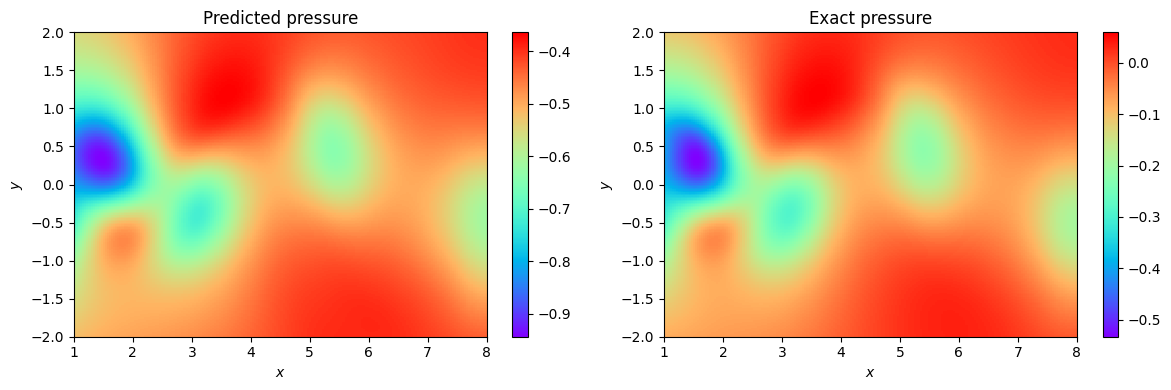

Sauvegardé : /content/pressure_comparison_adam_lbfgs.png


In [8]:


# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":

    print("Loading the data...")
    try:
        data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")
    except FileNotFoundError:
        print("Erreur: /content/cylinder_nektar_wake.mat introuvable.")
        exit()

    U_star = data["U_star"]
    t_star = data["t"]
    X_star = data["X_star"]

    N_val = 2000
    idx = np.random.choice(X_star.shape[0] * t_star.shape[0], N_val, replace=False)

    XX = np.tile(X_star[:, 0:1], (1, t_star.shape[0])).flatten()
    YY = np.tile(X_star[:, 1:2], (1, t_star.shape[0])).flatten()
    TT = np.tile(t_star, (1, X_star.shape[0])).T.flatten()
    UU = U_star[:, 0, :].flatten()
    VV = U_star[:, 1, :].flatten()

    x_val = torch.tensor(XX[idx][:, None], dtype=torch.float32).to(device)
    y_val = torch.tensor(YY[idx][:, None], dtype=torch.float32).to(device)
    t_val = torch.tensor(TT[idx][:, None], dtype=torch.float32).to(device)
    u_val = torch.tensor(UU[idx][:, None], dtype=torch.float32).to(device)
    v_val = torch.tensor(VV[idx][:, None], dtype=torch.float32).to(device)

    # Pour le MLP: pas de unsqueeze supplémentaires
    xyt_val = torch.cat([x_val, y_val, t_val], dim=1)
    xyt_val.requires_grad_(True)

    # u_val et v_val restent (N, 1) pour le MLP

    # ---------------------------------------------------------
    # Generating landscapes
    # ---------------------------------------------------------
    generate_landscape_plot(
        "/content/navier_adam_lbfgs_model.pth",
        "/content/navier_adam_lbfgs_traj.pt",
        "Adam + LBFGS",
        "/content/landscape_adam_lbfgs.png",
        xyt_val,
        u_val,
        v_val,
    )

    generate_landscape_plot(
        "/content/navier_adam_only_model.pth",
        "/content/navier_adam_only_traj.pt",
        "/content/Adam Only",
        "/content/landscape_adam_only.png",
        xyt_val,
        u_val,
        v_val,
    )

    generate_landscape_plot(
        "/content/navier_sgd_model.pth",
        "/content/navier_sgd_traj.pt",
        "SGD",
        "/content/landscape_sgd.png",
        xyt_val,
        u_val,
        v_val,
    )

    # ---------------------------------------------------------
    # Pressure Graph
    # ---------------------------------------------------------

    plot_pressure_field(
        model_path="/content/navier_adam_lbfgs_model.pth",
        data=data,
        snap_idx=100,
        output_name="/content/pressure_comparison_adam_lbfgs.png",
    )